<a href="https://colab.research.google.com/github/Azfarsh/AICancerScreen/blob/master/cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import json
import matplotlib.pyplot as plt
import numpy as np
import string, random
import pandas
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [ ]:
projectName = 'colorectal_histology'
dataset, info = tfds.load(projectName, split=f'train', as_supervised=True, with_info=True, shuffle_files=True)
dataset = dataset.shuffle(buffer_size=5000, reshuffle_each_iteration=True)
dataset = dataset.map(lambda img, lbl: (tf.cast(img, tf.float32) / 255.0, lbl))
print(f'dataset type {type(dataset)} with {len(dataset)} images')
print(info.supervised_keys)
print(info.features.items())

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/incomplete.EL9L6X_2.0.0/colorectal_histology-train.tf…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.
dataset type <class 'tensorflow.python.data.ops.map_op._MapDataset'> with 5000 images
('image', 'label')
dict_items([('image', Image(shape=(150, 150, 3), dtype=uint8)), ('label', ClassLabel(shape=(), dtype=int64, num_classes=8)), ('filename', Text(shape=(), dtype=string))])


In [ ]:
class_names = ["tumor", "stroma", "complex", "lympho", "debris", "mucosa", "adipose", "empty"]

In [ ]:
batch_size = 64
valid_data = dataset.take(1000)
valid_data = valid_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

test_data = dataset.skip(1000).take(1000)
test_data = test_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

train_data = dataset.skip(2000).take(3000)
train_data = train_data.cache().batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer((150, 150, 3)),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Conv2D(128, 3, activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(8, activation='softmax')
], name='cnn_model')

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])
print(model.summary())

Model: "cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 110,792 (432.78 KB)

 Trainable params: 110,792 (432.78 KB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
model_name = 'CNN'+''.join(random.sample(string.ascii_lowercase, 12))
earlystop = tf.keras.callbacks.EarlyStopping('val_loss', patience=20, verbose=1, restore_best_weights=True)
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=f'/content/drive/My Drive/ckpts/{projectName}-{model_name}-' + '{epoch:02d}-{val_loss:.2f}.keras',
    monitor='val_loss',
    save_best_only=True
)

In [ ]:
history = model.fit(train_data, validation_data=valid_data, epochs=100,callbacks=[earlystop, checkpoint])

Epoch 1/400
47/47 ━━━━━━━━━━━━━━━━━━━━ 32s 353ms/step - accuracy: 0.1696 - loss: 1.9464 - val_accuracy: 0.3210 - val_loss: 1.4756
Epoch 2/400
47/47 ━━━━━━━━━━━━━━━━━━━━ 13s 50ms/step - accuracy: 0.3872 - loss: 1.4181 - val_accuracy: 0.5560 - val_loss: 1.1006
Epoch 3/400
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.5070 - loss: 1.1033 - val_accuracy: 0.6350 - val_loss: 0.9194
Epoch 4/400
47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.5641 - loss: 0.9684 - val_accuracy: 0.5420 - val_loss: 0.8956
Epoch 5/400
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6082 - loss: 0.9107 - val_accuracy: 0.5710 - val_loss: 0.8370
Epoch 6/400
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.6143 - loss: 0.8815 - val_accuracy: 0.6880 - val_loss: 0.7731
Epoch 7/400
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - accuracy: 0.6401 - loss: 0.8416 - val_accuracy: 0.7370 - val_loss: 0.7445
Epoch 8/400
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - accuracy: 0.6634 - loss: 0.7974 - val_accuracy:

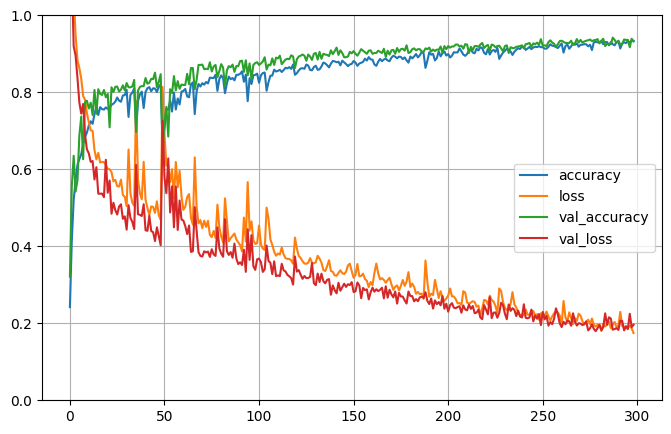

16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9471 - loss: 0.1510
[0.16177277266979218, 0.9430000185966492]


In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()
print(model.evaluate(test_data))

In [ ]:
betterModel = tf.keras.models.load_model('/content/drive/MyDrive/ckpts/colorectal_histology-CNNgnewroaijqct-279-0.18.keras')
test_loss, test_acc = betterModel.evaluate(test_data)
print(f'Test accuracy: {test_acc * 100:.2f}%')

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - accuracy: 0.9471 - loss: 0.1510
Test accuracy: 94.30%


In [ ]:
import tensorflow as tf
import os
print(os.getcwd())
# Load an actual image file (replace 'path/to/your/image.jpg' with the correct path)
image = tf.keras.preprocessing.image.load_img('/content/th.jpg', target_size=(150, 150))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
input_arr = input_arr.astype('float32') / 255.0 # Normalize the image

/content


In [ ]:
predictions = betterModel.predict(input_arr)
print(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[9.2805088e-01 1.5856499e-03 4.5325756e-02 2.3590842e-06 2.5035135e-02
  2.9346495e-07 2.9352349e-20 2.1721839e-17]]


In [ ]:
class_names = ["tumor", "stroma", "complex", "lympho", "debris", "mucosa", "adipose", "empty"]

predicted_class = np.argmax(predictions, axis=1)
predicted_class_name = class_names[predicted_class[0]]
print(f'Predicted class name: {predicted_class_name}')

Predicted class name: tumor
